### What to include:

- SQL code
- 2 to 3 EDA graphs
- Both regression models
- 2-3 Stat tests
    * Motivations/need for stat test
    * Brief background of stat test
    * Stat test
    * Result of test
    * Analysis
- Write up

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%run helper.py

In [39]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(5,5))
sns.set_style('darkgrid')

In [40]:
health = pd.read_csv('../data/interim/health.csv')
insecurity = pd.read_csv('../data/interim/insecurity.csv')
price = pd.read_csv('../data/interim/price_taxes.csv')
regression_long = pd.read_csv('../data/processed/regression_long.csv')
regression_short = pd.read_csv('../data/processed/regression_short.csv')
supp_county = pd.read_csv('../data/interim/supp_county.csv')

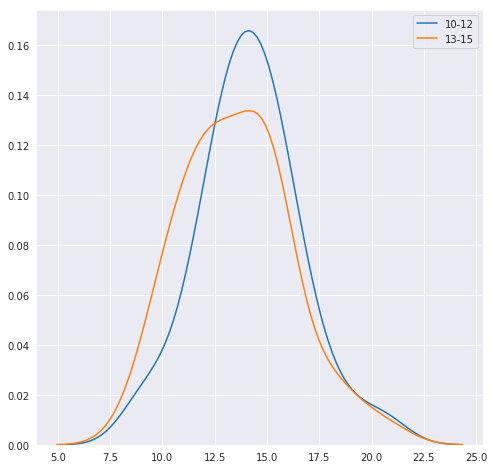

In [41]:
plt.figure(figsize=(8, 8))

sns.kdeplot(regression_short['state_FOODINSEC_10_12'], label='10-12')
sns.kdeplot(regression_short['state_FOODINSEC_13_15'], label='13-15')
plt.legend()

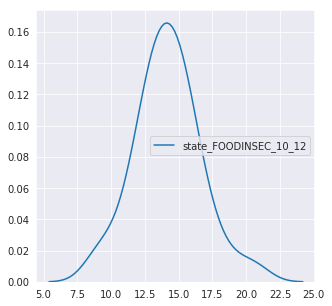

Sharpio-Wilk Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed


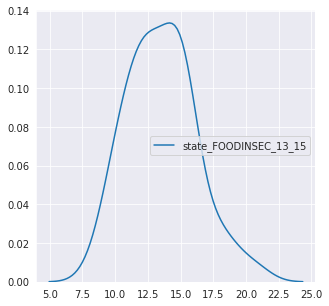

Sharpio-Wilk Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed


In [44]:
test_normality(regression_short, 'state_FOODINSEC_10_12')
test_normality(regression_short, 'state_FOODINSEC_13_15')

In [45]:
stats.ttest_rel(regression_short['state_FOODINSEC_10_12'],
                regression_short['state_FOODINSEC_13_15'])

Ttest_relResult(statistic=2.878865632380211, pvalue=0.005858791185468704)